In [2]:
#embedding method round 2

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation

import numpy as np



class LDAembedder(object):

    def __init__(self, **kwargs):

        if kwargs:

            self.vectorizer = kwargs['counter']

            self.feature_names = self.vectorizer.get_feature_names()

            self.lda_model = model

        else:

            if kwargs['max_features']:

                max_features = kwargs['max_features']

            else:

                max_features = 100000

            self.vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', max_features = max_features)

            self.feature_names = None

            self.lda_model = None





    def display_topics(self, n_top_words, topic_n = None):

        '''

        Display the top n words for each topic in the model.



        Input:

            n_top_words(int) : the number of words to display for each topic

            (Optional)

            topic_n(int) : if specified, only diplay the topic_nth topic

        '''

        model = self.lda_model

        feature_names = self.feature_names



        if model and feature_names:

            if topic_n:

                topic = model.components_[topic_n]

                print("Topic %d:" % topic_n)

                print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))

            else:

                for topic_index, topic in enumerate(model.components_):

                    print("Topic %d:" % topic_index)

                    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))

        else:

            raise Exception('You have to train before display')





    def fit(self, texts, n = 100):

        '''

        Train the LDA with n number of topics



        Input:

            texts(list) : list of documents. Each item in the list is a string type

            n(int) : number of topics, if not specified n = 100

        '''

        count = self.vectorizer.fit_transform(texts)

        self.feature_names = self.vectorizer.get_feature_names()

        model = LatentDirichletAllocation(n_topics=n).fit(count)

        self.lda_model = model



    def embed(self, text, method = 'additive'):

        '''

        embed the review text into k-dimensional topic vector



        Input:

            text(string) : a document to embed

            method(string) : 'additive' or 'multiplicative'



        Output:

            the vector of length k (k = number of topics)

        '''

        tokenizer = self.vectorizer.build_analyzer()

        count = self.vectorizer.transform(tokenizer(text))



        dirich = self.lda_model.transform(count)

        if method == 'additive':

            total = np.array([1]*dirich[0])

            for i in dirich:

                total = np.add(total, i)

            return total / sum(total)

        elif method == 'multiplicative':

            product = np.array([1]*dirich[0])

            for i in dirich:

                product = np.multiply(product, i)

            return product / sum(product)

        else:

            return dirich

In [3]:
path1 = "C:\\Users\\cdchang\\chinese.pkl"
path2 = "C:\\Users\\cdchang\\chinese_counter.pkl"

In [4]:
#testing the new embedder

import nltk
import pickle

# load the pre-trained model
with open(path2, "rb") as f:
    vectorizer = pickle.load(f)
with open(path1, "rb") as f:
    model = pickle.load(f)

lda = LDAembedder(model = model, counter = vectorizer)

# print top 10 words from each topic
lda.display_topics(10)

# embed text
sample = 'This place is horrible, we were so excited to try it since I got a gift card for my birthday. We went in an ordered are whole meal and they did not except are gift card, because their system was down. Unacceptable, this would have been so helpful if we would have known this prior!!'

add = lda.embed(sample, 'additive')
prod = lda.embed(sample, 'multiplicative')

print(add[0])

C:\Users\cdchang\Anaconda3\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\cdchang\Anaconda3\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Topic 0:
location los new angeles judge book like restaurant cover lucky
Topic 1:
steak eggs rare bo pho like good meatballs hue medium
Topic 2:
english chinese speak food mandarin menu don like really language
Topic 3:
cantonese chinese tin just restaurant silver summerlin gigantic road laws
Topic 4:
milk coffee tea bread breakfast came drink toast like ham
Topic 5:
shrimp fried rice great walnut food chicken honey house good
Topic 6:
sour chicken sweet hot soup kung pao good hakka food
Topic 7:
really place food good chinese nice just try surprised mom
Topic 8:
congee fried rice queen dough turnip place food preserved chinese
Topic 9:
options variety choose fresh meat veggies lots choices meats menu
Topic 10:
wonderful mother family great fin shark dinner nest divine food
Topic 11:
ho pizza mi flavours waffle sandwich banh waffles loving sandwiches
Topic 12:
shrimp rice pork mai siu fried steamed ribs egg har
Topic 13:
chicken food ordered like sauce just meat tasted soggy dry
Topic 

0.00390625


In [11]:
#json file setup in notebook

import json
import pandas as pd

def json_df(datapass):
    '''
    Load the json file and parse the file to pandas dataframe format
    
    Input:
        datapass(str) : directory to the json file
    Output:
        df(dataframe) : pandas dataframe object
    '''
    
    data = [] 
    with open(datapass, 'r', encoding='utf-8') as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

#business and review json files --> dataframes

DATAPASS1 = 'C:\\Users\\cdchang\\Downloads\\yelp_dataset\\dataset\\business.json'
DATAPASS2 = 'C:\\Users\\cdchang\\Downloads\\yelp_dataset\\dataset\\review.json'

#business = json_df(DATAPASS1)
reviews = json_df(DATAPASS2)

In [8]:
#old methods from past weeks

def business_id_retrieval(cat, business):
    '''
    Input:
        cat(str) : category
        business(dataframe) : the business data
    Output:
        id_list(set) : business ids of a particular category
    '''
    id_list = set()
    id_list = []
    idx = 0
    for row in business.values:
        categories = row[3]
        if cat in categories:
            id_list.append(row[2])
            
    return id_list

def examine_reviews2(cat, business, reviews): #across entire category
    '''
    concatenate a category's review text with the corresponding dates for time series analysis
    Input: specific category, review json file
    Output: concatenated review text & date columns for a particular category (not business specific) 
    '''
    id_list = business_id_retrieval(cat, business)
    return reviews.loc[reviews['business_id'].isin(id_list)]

def examine_reviews(b_id, reviews):
    '''
    concatenate a particular business's review text with the corresponding dates for time series analysis
    
    Input: specific business id, review json file
    Output: concatenated review text & date columns for a particular business id
    '''
    subset = reviews.loc[reviews['business_id'] == b_id]
    date = subset.loc[:, 'date']
    text = subset.loc[:, 'text']
    return pd.concat([date, text], axis=1, join='inner')

In [9]:
#end of set-up cells
#pre-processing / grouping of appropriate data
#TODO: we need 
compilation = examine_reviews2("Chinese", business, reviews)
idlist = business_id_retrieval("Chinese", business)
singular_subset = examine_reviews("jQsNFOzDpxPmOurSWCg1vQ", reviews)


def df_allcomp(b_id):
    subset = reviews.loc[reviews['business_id']==b_id]
    date = subset.loc[:,'date']
    text = subset.loc[:,'text']
    stars = subset.loc[:,'stars']

    df = pd.concat([date,text,stars],axis=1, join='inner')
    return df

#still needs to be ordered
df1 = df_allcomp("jQsNFOzDpxPmOurSWCg1vQ")
df1

,date,text,stars
16,2017-06-03,"This place is horrible, we were so excited to ...",1
17,2015-03-26,"For being fairly ""fast"" food.. Pei Wei (pronou...",4
18,2012-12-30,"I decided to try it out, I'm celiac and theref...",5
19,2009-01-12,I'm not saying Pei Wei is the best asian food ...,3
20,2015-07-11,Sometimes the food is spot on and delicious an...,3
21,2015-05-27,Decent customer service but the food was awful...,1
22,2015-02-28,Super clean restaurant and friendly staff. FRE...,5
23,2010-04-05,Found this the other night. It is the PF Chan...,4
24,2015-05-22,"The staff here is great and they're nice, won...",1
25,2011-06-15,I had the garlic ginger broccoli chicken and i...,2


In [21]:
#topic filtering ....

import numpy as np
#svm
from sklearn import datasets
from sklearn import svm

clf = svm.SVC(gamma = 0.001, C=100)
x = np.array(range(0,92))
newx = x.reshape(-1,1)
y = df1.stars[:-10]
#x should be a cerain number of topics, y should be star rating
clf.fit(newx,y)

ValueError: Found input variables with inconsistent numbers of samples: [92, 82]

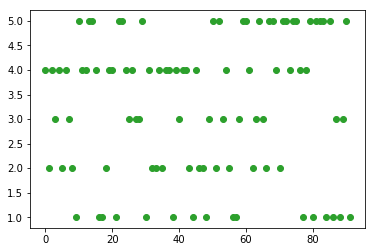

In [23]:
#do it star-type by star-type ??

#
import matplotlib.pyplot as plt
# "jQsNFOzDpxPmOurSWCg1vQ"
collection = df_allcomp("jQsNFOzDpxPmOurSWCg1vQ")
#x = range(0,92)
s = collection.sort_values(by="date") #sorting by timestamp

x = np.array(range(0,92))
plt.scatter(x,s.stars)
plt.show()

In [35]:
collection = df_allcomp("jQsNFOzDpxPmOurSWCg1vQ")
s = collection.sort_values(by="date") #sorting by timestamp
s.date

40      2008-10-06
72      2008-11-27
65      2008-12-02
19      2009-01-12
79      2009-01-19
51      2009-01-24
39      2009-06-25
63      2009-10-06
35      2009-11-18
46      2009-12-10
54      2010-01-10
23      2010-04-05
58      2010-07-02
55      2010-07-04
64      2010-10-04
83      2010-11-19
80      2010-12-29
60      2011-02-27
25      2011-06-15
28      2011-08-10
85      2011-09-15
9527    2011-10-22
9532    2012-03-17
67      2012-07-08
36      2012-07-29
38      2012-08-23
59      2012-09-11
33      2012-10-08
9529    2012-10-09
18      2012-12-30
           ...    
32      2015-09-22
56      2015-10-29
53      2015-11-01
30      2015-11-03
82      2015-11-07
34      2015-12-28
9536    2016-01-31
66      2016-02-13
49      2016-02-14
77      2016-03-02
70      2016-03-17
9528    2016-03-20
43      2016-05-07
61      2016-05-31
37      2016-06-19
81      2016-08-28
9537    2016-10-31
27      2016-12-19
88      2017-01-24
87      2017-03-06
26      2017-03-12
69      2017

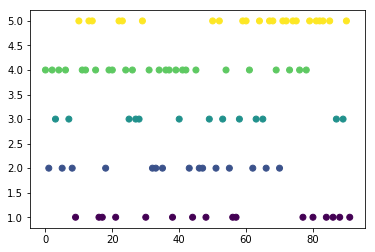

In [52]:
#separation by type

from sklearn import svm
clf = svm.SVC(kernel='linear', C = 5.0)
x = x.reshape(-1,1)
clf.fit(x,s.stars)

#w = clf.coef_[0]
#print(w)

plt.scatter(x, s.stars, c=s.stars)
plt.show()

In [50]:
#not a successful attempt...
clf.predict(x)
#clf.decision_function(x)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64)

In [10]:
#set-up

from sklearn import datasets
from sklearn import svm
import numpy as np
clf = svm.SVC(kernel='linear', C=1.0)
import matplotlib.pyplot as plt

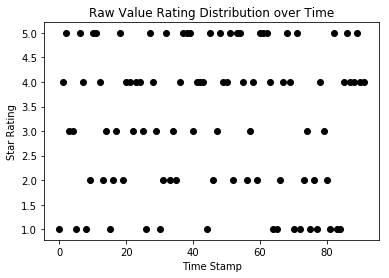

In [61]:
#SVM official training
#raw value rating distribution over time

subset = reviews.loc[reviews['business_id']=="jQsNFOzDpxPmOurSWCg1vQ"]
date = subset.loc[:,'date']
text = subset.loc[:,'text']
stars = subset.loc[:,'stars']
x = np.array(list(range(0,92)))

plt.scatter(x,stars, c="k")
plt.title("Raw Value Rating Distribution over Time")
plt.xlabel("Time Stamp")
plt.ylabel("Star Rating")
plt.show()

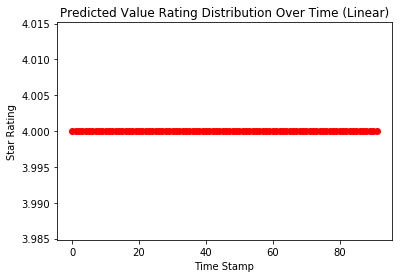

In [64]:
#linear kernel not the answer

clf = svm.SVC(kernel='linear', C = 1.0)
x=x.reshape(-1,1)
clf.fit(x,stars)
plt.scatter(x,clf.predict(x),color="r")
plt.title("Predicted Value Rating Distribution Over Time (Linear)")
plt.xlabel("Time Stamp")
plt.ylabel("Star Rating")
plt.show()

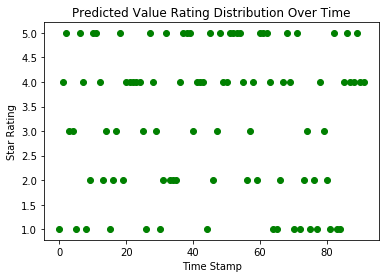

In [63]:
#training and predicting
#predicted value rating distribution over time

#rbf kernel works better - thus, this isn't a self-fulfilling prophecy
clf = svm.SVC(kernel='rbf', C = 1.0)
x=x.reshape(-1,1)
clf.fit(x,stars)

plt.scatter(x,clf.predict(x), color="g")
plt.title("Predicted Value Rating Distribution Over Time")
plt.xlabel("Time Stamp")
plt.ylabel("Star Rating")
plt.show()

In [116]:
#binning by year
import datetime
s["date"] = pd.to_datetime(s["date"])
s["date"][0:1].dt.month
s["date"][0:1]

s.groupby(s["date"].dt.year)

min_year=s.date.iloc[0].year
max_year = s.date.iloc[91].year

subset = s[(s['date']>datetime.date(2016,1,1)) & (s['date']<datetime.date(2016,3,1))]  
subset
#"33"+str(min_year)
#subset = s(date[0:3]==str(min_year),text,stars)
#subset(studentdata, Drink=='water')
#s.date.iloc[date(year=min_year,month=1,day=1):date(year=2014,month=12,day=31)]

,date,text,stars
9536,2016-01-31,Pei Wei will always hold a special place in my...,5
66,2016-02-13,Pretty good food a chain. You do get a lot of ...,4
49,2016-02-14,"OH MY GOD, this place. I used to like Pei Wei ...",2
